In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.neighbors import KDTree

mpl.rc('font', size=15)

In [2]:
degtorad = np.pi/180.
radtodeg = 180./np.pi

In [3]:
# convert ROOT histogram into numpy arrays
def convert_to_array(hist):
    n = hist.GetNbinsX()   # number of bins
    axis = hist.GetXaxis() 
    
    # output
    bins = np.empty(n+1)
    entries = np.empty(n)
    for i in xrange(n):
        entries[i] = hist.GetBinContent(i+1)
        bins[i] = axis.GetBinLowEdge(i+1)
    bins[i+1] = axis.GetBinUpEdge(n)
    
    return entries, bins

# Compute DD(s)
## Import and convert data into KDTree

In [4]:
filename = "/home/chris/project/bao/correlation/catalog/boss/randoms_DR9_CMASS_North_DC.dat"
s_max = 200

# import data and convert to x-y-z coordinate
# conversion equation is
# x = r*cos(dec)*cos(ra)
# y = r*cos(dec)*sin(ra)
# z = r*sin(dec)
ra, dec, r, w = np.genfromtxt(filename, skip_header = 1, unpack = True)
ra = degtorad*ra
dec = degtorad*dec
x = r*np.cos(dec)*np.cos(ra)
y = r*np.cos(dec)*np.sin(ra)
z = r*np.sin(dec)

# create KDTree
data = np.array([x, y, z, w]).T
tree = KDTree(data, leaf_size=1, metric='euclidean')

## Compute DD(s)

In [22]:
f = np.load('../data_data.npz')
dd_w = f['DD_w']
dd_u = f['DD_u']

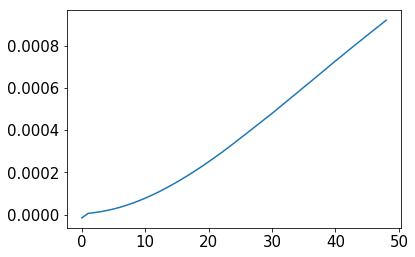

In [26]:
plt.plot(dd_w/8.80294298e+08)

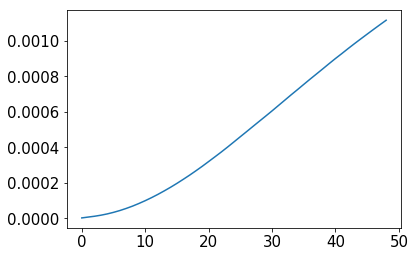

In [24]:
plt.plot(dd_u/2.14755559e+10)

In [9]:
# compute DD(s)
dd = np.zeros((2,50))
for i, point in enumerate(data):
    if i%10000 is 0:
        print(i)
    index, dist = tree.query_radius(point.reshape(1,-1), r=s_max, return_distance=True)
    weight = data[:, 3][index[0]]
    h,_  = np.histogram(dist[0], bins=50, range=(0., s_max), weights=weight) 
    dd += h

0
10000
20000
30000


KeyboardInterrupt: 

In [13]:
# normalize
# unweighted
n = len(data)
norm_dd = n*(n-1)
dd[0] -= n
dd_norm = dd/norm_dd

## Compare with ROOT DD(s)

In [14]:
root_filename = "/home/chris/project/bao/correlation/tpcf/out/BOSS_North.root"

#import ROOT histogram and convert to NumPy array
rootfile = root_open(root_filename, "read")
dd_root, bins_root = convert_to_array(rootfile.Get("Unweighted").Get("data_data_uw"))

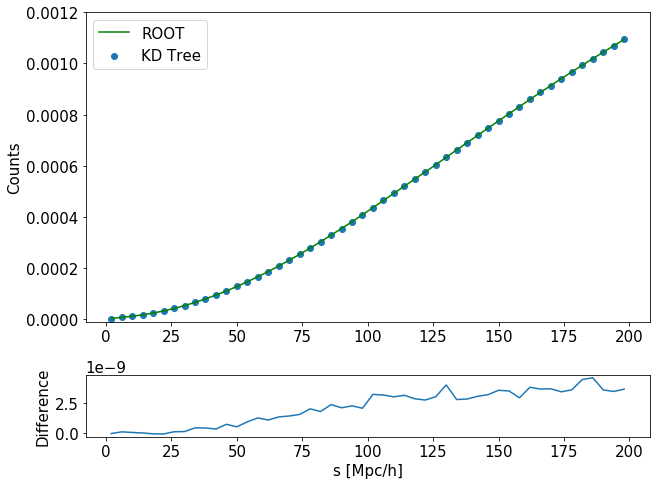

In [15]:
fig = plt.figure(figsize=(12,7))
gs  = gridspec.GridSpec(2, 2, width_ratios=[10,3], height_ratios=[10,2])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2], sharex = ax1)

# plot two histograms on top of each other
x = 0.5*(bins[:-1]+bins[1:])
ax1.scatter(x, dd_norm, label = 'KD Tree')
ax1.plot(x, dd_root, color = 'g', label = 'ROOT')
ax1.set(ylim = [-0.00001,0.0012],
        ylabel='Counts')

ax2.plot(x, dd_norm-dd_root)
ax2.set(xlabel='s [Mpc/h]',
        ylabel='Difference')

ax1.legend()
fig.tight_layout()

## Save

In [35]:
np.savez("dd.npz", DD=dd_norm, BINS=bins)